# Map Construction


Primarily adding disputed areas to the countries table. That way when we join the participants/outreach programs with the maps we will have a full join. 

Country codes json: [**here!**](https://comtrade.un.org/data/cache/partnerAreas.json)

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
student_f = '../data/canonical/participant-data.csv'
student_df = pd.read_csv(student_f)

country_f = '../data/canonical/country-counts.csv'
country_cnts_df = pd.read_csv(country_f)

outreach_f = '../data/canonical/outreach-programs.csv'
outreach_df = pd.read_csv(outreach_f)

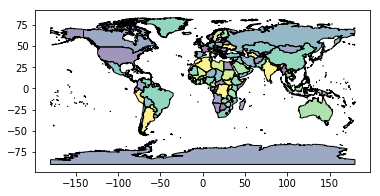

In [3]:
# new maps
maps_d = '../data/maps/'

countries_map_f = maps_d + "ne_50m_admin_0_countries.geojson"
country_map_df = gpd.read_file(countries_map_f)

country_map_df.plot()

In [4]:
print ("{} rows".format(len(country_map_df)))
print (country_map_df.columns)
country_map_df.head(3)

241 rows
Index(['abbrev', 'abbrev_len', 'adm0_a3', 'adm0_a3_is', 'adm0_a3_un',
       'adm0_a3_us', 'adm0_a3_wb', 'adm0_dif', 'admin', 'brk_a3', 'brk_diff',
       'brk_group', 'brk_name', 'continent', 'economy', 'featurecla',
       'fips_10', 'formal_en', 'formal_fr', 'gdp_md_est', 'gdp_year',
       'geometry', 'geou_dif', 'geounit', 'gu_a3', 'homepart', 'income_grp',
       'iso_a2', 'iso_a3', 'iso_n3', 'labelrank', 'lastcensus', 'level',
       'long_len', 'mapcolor13', 'mapcolor7', 'mapcolor8', 'mapcolor9', 'name',
       'name_alt', 'name_len', 'name_long', 'name_sort', 'note_adm0',
       'note_brk', 'pop_est', 'pop_year', 'postal', 'region_un', 'region_wb',
       'scalerank', 'sov_a3', 'sovereignt', 'su_a3', 'su_dif', 'subregion',
       'subunit', 'tiny', 'type', 'un_a3', 'wb_a2', 'wb_a3', 'wikipedia',
       'woe_id'],
      dtype='object')


,abbrev,abbrev_len,adm0_a3,adm0_a3_is,adm0_a3_un,adm0_a3_us,adm0_a3_wb,adm0_dif,admin,brk_a3,...,su_dif,subregion,subunit,tiny,type,un_a3,wb_a2,wb_a3,wikipedia,woe_id
0,Aruba,5.0,ABW,ABW,-99.0,ABW,-99.0,1.0,Aruba,ABW,...,0.0,Caribbean,Aruba,4.0,Country,533,AW,ABW,-99.0,-99.0
1,Afg.,4.0,AFG,AFG,-99.0,AFG,-99.0,0.0,Afghanistan,AFG,...,0.0,Southern Asia,Afghanistan,-99.0,Sovereign country,004,AF,AFG,-99.0,-99.0
2,Ang.,4.0,AGO,AGO,-99.0,AGO,-99.0,0.0,Angola,AGO,...,0.0,Middle Africa,Angola,-99.0,Sovereign country,024,AO,AGO,-99.0,-99.0


In [15]:
# take a look at which columns would be best suited for selection
country_map_df[['admin', 'brk_name', 'formal_en', 'geounit', 'name',
             'name_sort', 'sovereignt', 'subunit', 'type']].to_csv('../country-names.csv', index=False)

In [6]:
country_map_df = country_map_df[['name_sort', 'name', # for naming
                                 'adm0_a3', 'scalerank',  # for filtering
                                 'geometry' # for mapping
                                ]]

#### Filtering the Map

In [7]:
print ("Orig:\t{} rows".format(len(country_map_df)))

# remove antartica
country_map_df = country_map_df[country_map_df['adm0_a3'] != 'ATA']

# remove small islands
country_map_df = country_map_df[country_map_df['scalerank'] == 1]

print ("Modf:\t{} rows".format(len(country_map_df)))

Orig:	241 rows
Modf:	195 rows


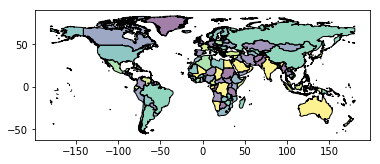

In [8]:
country_map_df.plot()

In [9]:
# Renaming

# old columns >> name_sort	name	adm0_a3	scalerank	geometry
new_cols = ['country', 'name', 'adm0_a3', 'scalerank', 'geometry']
country_map_df.columns = new_cols

# drop unneeded columns
country_map_df.drop(['adm0_a3', 'scalerank'], axis=1, inplace=True)

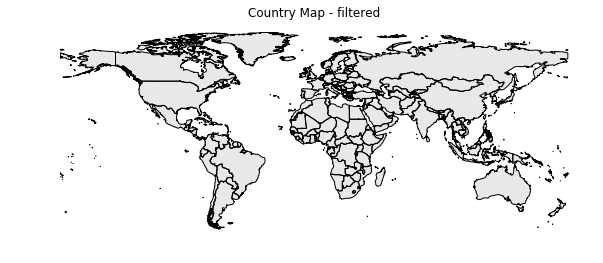

In [37]:
fig, ax = plt.subplots(1, figsize=(10, 10))
country_map_df.plot(ax=ax, color='lightgray')

ax.set_aspect('equal')
_ = ax.axis('off')
ax.set_title("Country Map - filtered")

In [38]:
# Write raw map out
web_map_f = '../data/canonical/web-map.geo.json'
country_map_df.to_file(filename=web_map_f, driver="GeoJSON")

#### Join map for choropleth

In [31]:
# Outreach country counts data frame
outreach_cnts = outreach_df.country.value_counts()

outreach_cnts = outreach_cnts.reset_index()
outreach_cnts.columns = ['country', 'outreach_cnt']

print ("{} countries in outreach".format(len(outreach_cnts)))
outreach_cnts.head()

33 countries in outreach


,country,outreach_cnt
0,China,5
1,Jordan,3
2,Greece,3
3,Turkey,3
4,United Arab Emirates,2


In [35]:
# Outreach country counts map layer
outreach_layer = country_map_df.merge(outreach_cnts, on='country')

In [34]:
# Participant country counts map layer

print ("{} uniq. countries from participants".format(len(country_cnts_df)))

participant_layer = country_map_df.merge(country_cnts_df, on='country')

print ("{} uniq. countries in merge".format(len(participant_layer)))

31 uniq. countries from participants
31 uniq. countries in merge


In [38]:
out_layer_f = 'test-outreach.shp'
part_layer_f = 'test-participants.shp'

participant_layer.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
outreach_layer.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

participant_layer.to_file(out_layer_f, driver='ESRI Shapefile')
outreach_layer.to_file(part_layer_f, driver='ESRI Shapefile')

In [20]:
# both in one dataframe

choro_layer = outreach_cnts.merge(country_cnts_df, on='country', how='outer')
choro_layer.columns = ['country', 'outreach_cnt', 'participant_cnt']
choro_layer.head(10)

,country,outreach_cnt,participant_cnt
0,China,5.0,2.0
1,Jordan,3.0,14.0
2,Greece,3.0,NaN
3,Turkey,3.0,7.0
4,United Arab Emirates,2.0,NaN
5,Kenya,2.0,NaN
6,Oman,1.0,2.0
7,Maldives,1.0,NaN
8,India,1.0,3.0
9,Bahrain,1.0,12.0


In [29]:
country_map_df.merge(choro_layer, on='country')

,country,name,geometry,outreach_cnt
0,Afghanistan,Afghanistan,"POLYGON ((74.89130859375001 37.231640625, 74.8...",1.0
1,United Arab Emirates,United Arab Emirates,(POLYGON ((53.92783203125001 24.17719726562498...,2.0
2,Armenia,Armenia,(POLYGON ((45.55234375000006 40.61606445312506...,1.0
3,Bahrain,Bahrain,"POLYGON ((50.60722656250002 25.88310546875, 50...",1.0
4,Bolivia,Bolivia,"POLYGON ((-58.159765625 -20.16464843750001, -5...",1.0
5,China,China,(POLYGON ((110.8887695312501 19.99194335937497...,5.0
6,Colombia,Colombia,(POLYGON ((-78.11372070312495 2.54174804687502...,1.0
7,Cuba,Cuba,(POLYGON ((-82.56176757812503 21.5716796875000...,1.0
8,Cyprus,Cyprus,"POLYGON ((32.71269531250002 35.17104492187499,...",1.0
9,Ecuador,Ecuador,(POLYGON ((-80.131591796875 -2.973144531249957...,1.0
